# Zero_One_Classification.py

### Tensorflow, pandas 라이브러리 추가

In [22]:
import tensorflow as tf #Tensorflow 추가
import pandas as pd #pandas추가
import numpy as np #numpy 추가

### 입력 데이터(pixel_data, label_data), 테스트 데이터(test_pixel, test_label)

In [23]:
pixel_data = [[0, 1, 0, 1, 1, 1, 1, 1, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0], [1, 1, 0, 1, 1, 0, 1, 1, 0], [0, 1, 1, 0, 1, 1, 0, 1, 1], [0, 1, 0, 1, 1, 1, 1, 1, 1], [1, 1, 0, 1, 0, 1, 1, 1, 1],[0, 1, 0, 0, 1, 0, 0, 1, 0], [0, 1, 0, 1, 1, 0, 1, 1, 0], [0, 0, 1, 0, 1, 1, 0, 1, 0], [0, 0, 1, 0, 0, 1, 1, 1, 1], [0, 0, 1, 0, 1, 1, 0, 1, 0], [0, 1, 0, 0, 1, 0, 0, 0, 1]] #내가 작성한 픽셀 데이터

label_data = [[0],[0],[0],[0],[0],[0],[1],[1],[1],[1],[1],[1]] #내가 작성한 픽셀 데이터의 Label 값

test_pixel = [[1, 1, 1, 1, 0, 1, 1, 1, 1],[0, 1, 0, 0, 1, 0, 0, 0, 1]] #학습된 모델 테스트에 사용할 픽셀 데이터

test_label = [[0],[1]] #학습된 모델 테스트에 사용할 Label 값

### Tensorflow로 작성한 그래프를 시각화하기 위한 코드

In [24]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

### tensorflow 라이브러리를 이용하여 네트워크 만들기
#### Input Layer 노드의 수 : 9개
#### Hidden Layer 노드의 수 : 1개
#### Output Layer 노드의 수 : 1개

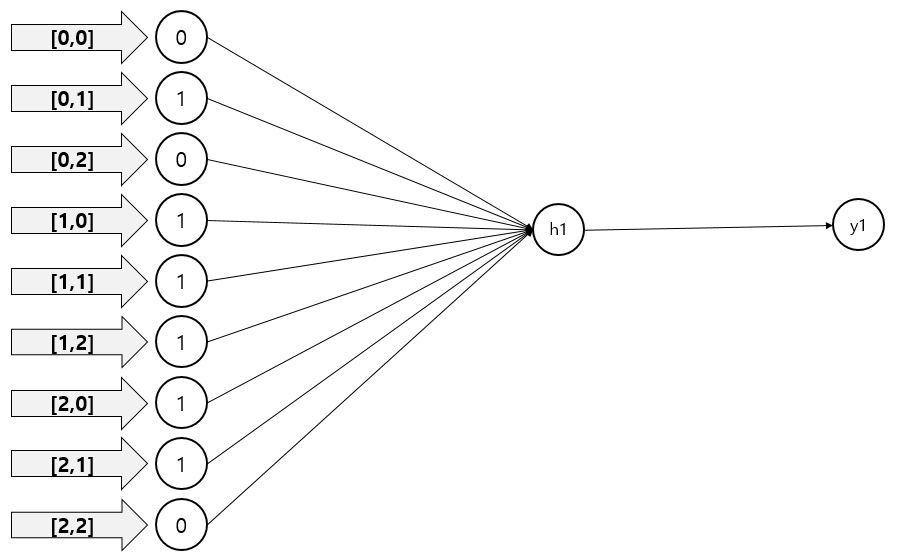

In [25]:
sess = tf.Session()
#Tensorflow에서 값을 처리하기 위해 필요한 Session 유형의 변수를 sess로 생성

with tf.name_scope('Input') as scope: 
    X = tf.placeholder(tf.float32, shape=([None,9]),name="X") #9개의 픽셀 데이터에 대한 Tensor
#shape=(None, 9) : 입력하는 개수가 많을때는 정확히 알 수 없음(None), 한 번에 입력할 때 들어가는 데이터의 특징의 수 : 픽셀 9칸 -> 9
#Input Layer 노드의 수 = 9

with tf.name_scope('Output') as scope :
    Y = tf.placeholder(tf.int32, shape=([None,1]),name="Y") #X에 입력한 픽셀의 실제 Label 값에 대한 Tensor
#shape=(None, 1) : Output Layer의 노드의 수 = 1
    Y_one_hot = tf.one_hot(Y, 2, name="Y_one_hot")  #Output Layer 노드의 수가 1개로 0인지 1인지 구별하기 위해 사용하는 방법이 One-hot encoding
    Y_one_hot = tf.reshape(Y_one_hot, [-1, 2]) #[-1, 2]의 형태로 변환 -> -1 : 몇 개의 데이터를 사용할 지 모른다는 의미, 2 : 0, 1로 구별하겠다는 의미 

#첫번째 Hidden Layer 설정
with tf.name_scope('Hidden') as scope :
    W1 = tf.Variable(tf.random_normal([9,2]),name='W1') #Input Layer의 각 노드에 대한 가중치(Weight)
#W1 : 첫번째 Hidden Layer의 노드 1개, 가중치는 2 x 9 = 18개
        
    b1 = tf.Variable(tf.zeros([2]),name='b1') #Input Layer의 각 노드에 대한 편향(bias)
#b1 : 첫번째 Hidden Layer의 각 노드의 bias
        
logits = tf.matmul(X, W1) + b1 #입력한 데이터를 기반으로 가중치와 편향을 반영한 그래프
hypothesis = tf.nn.softmax(logits) #Softmax 함수를 hypothesis로 선정
#입력데이터와 출력 데이터의 관계(Relationship) 또는 패턴(Pattern)을 나타내기 위한 함수 : hypothesis
            
cost_i = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,labels=Y_one_hot) #Input Layer 노드 9개 각각에 대한 Cost계산
#Logits를 통해 그려진 그래프와, hypothesis를 통해 판별한 결과의 오차를 계산
            
cost = tf.reduce_mean(cost_i) #전체 9개 Input Node의 오차의 평균
    
optimization = tf.train.GradientDescentOptimizer(learning_rate=0.05).minimize(cost) #경사하강법(Gradient-Descent)를 이용하여 학습
#학습률(Learning_rate) : 0.05 -> 학습을 하는 과정에서 경사를 하강하는 폭의 정도 -> 작을 수록 폭이 좁음, 넓을 수록 폭이 넓음

prediction = tf.argmax(hypothesis, 1) #우리가 선정한 hypothesis 함수를 기반으로 Classification한 결과
correct_prediction = tf.equal(prediction, tf.argmax(Y_one_hot, 1)) #Prediction의 결과가 실제 Label 값과 맞는지 여부
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) #Prediction의 정확성을 저장하는 변수
            
sess.run(tf.global_variables_initializer()) #Tensorflow의 변수 초기화

### Tensorflow가 그려주는 그래프 보기

In [26]:
show_graph(tf.get_default_graph().as_graph_def())

In [27]:
for step in range(1001): #1001번 반복
    _ = sess.run(optimization, feed_dict={X:pixel_data,Y:label_data}) 
    #입력은 pixel_data, Prediction 결과 비교를 위한 Y는 lable_data로 사용하여 학습
    
    if step % 1000 == 0:
        loss, acc = sess.run([cost, accuracy], feed_dict={X: pixel_data, Y: label_data})
        print("Step: {:5}\tLoss: {:.3f}\tAcc: {:.2%}".format(step, loss, acc))

Step:     0	Loss: 1.160	Acc: 41.67%
Step:  1000	Loss: 0.364	Acc: 75.00%


In [28]:
test_acc,test_predict,test_correct = sess.run([accuracy,prediction,correct_prediction], feed_dict={X: test_pixel, Y: test_label})

print("Test Prediction =", test_acc)        
sub = pd.DataFrame() #Test 결과를 저장하기 위한 Data구조 생성
sub['Predict_Value'] = test_predict #모델이 예측한 값 
sub['Origin_Value'] = test_label #실제 Label 값
sub['Correct'] = test_correct #모델이 예측한 값과 실제 Label 값이 맞는지 여부

print(sub)

Test Prediction = 0.5
   Predict_Value Origin_Value  Correct
0              0          [0]     True
1              0          [1]    False
